In [ ]:
device = 'mps'


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import tqdm as tqdm


In [ ]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_dataset = torchvision.datasets.QMNIST('data', train=True, download=True, transform=transforms)
# test_dataset = torchvision.datasets.QMNIST('data', train=False, download=True, transform=transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training with {len(train_dataset)} samples")
# print(f"Testing with {len(test_dataset)} samples")


tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000], device='mps:0')


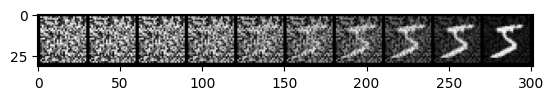

In [154]:
def noiser(img, noise, t, total_t):
    noise_scale = torch.as_tensor(torch.cos((t) * (3.1415/2)), device=device).view(-1, 1, 1, 1)
    return img * (1-noise_scale) + noise * (noise_scale)


x, y = next(iter(train_loader))
x = x.to(device)
y = y.to(device)

t = torch.arange(0, 10, device=device) / 10
print(t)
noise = torch.rand_like(x[0])
noised = noiser(x[0], noise, t, 10)
grid = torchvision.utils.make_grid(noised, nrow=10)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()


In [185]:
class DPM(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = nn.Conv2d(1, 16, 3, padding=1)
        self.down2 = nn.Conv2d(16, 32, 3, padding=1)
        self.down3 = nn.Conv2d(32, 64, 3, padding=1)
        
        self.mid1 = nn.Conv2d(64, 64, 3, padding=1)
        self.mid2 = nn.Conv2d(64, 64, 3, padding=1)
        
        self.up1 = nn.Conv2d(64, 64, 3, padding=1)
        self.up2 = nn.Conv2d(64, 32, 3, padding=1)
        self.up3 = nn.Conv2d(32, 16, 3, padding=1)
        
        self.out = nn.Conv2d(16, 1, 3, padding=1)
        
        self.time_embeds = nn.Linear(1, 28 * 28)
        self.class_embeds = nn.Linear(10, 28 * 28)
        
    def forward(self, x, y, t):
        t_emb = self.time_embeds(t.view(-1, 1))
        t_emb = t_emb.view(-1, 1, 28, 28)
        y_emb = self.class_embeds(F.one_hot(y, 10).float())
        y_emb = y_emb.view(-1, 1, 28, 28)
        
        x = x + t_emb
        x1 = F.silu(self.down1(x)) + t_emb + y_emb
        x2 = F.silu(self.down2(x1)) + t_emb + y_emb
        x3 = F.silu(self.down3(x2)) + t_emb + y_emb
        
        x4 = F.silu(self.mid1(x3)) + t_emb + y_emb
        x5 = F.silu(self.mid2(x4)) + t_emb + y_emb
        
        x6 = F.silu(self.up1(x5)) + t_emb + y_emb + x3
        x7 = F.silu(self.up2(x6)) + t_emb + y_emb + x2
        x8 = F.silu(self.up3(x7)) + t_emb + y_emb + x1
        
        x9 = self.out(x8)
        return x9

model = DPM().to(device)
criterion = F.mse_loss

print(f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters")
print(f"Model is using {sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / 1024 / 1024:.2f} MB of memory")


Model has 167,505 parameters
Model is using 0.64 MB of memory


In [196]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-8)
total_steps = 1000


Epoch 0:   0%|          | 1/1875 [00:02<56:15,  1.80s/it, Loss: 0.16631032526493073]

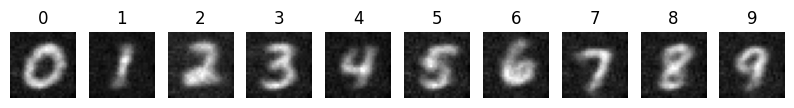

Epoch 0:  27%|██▋       | 501/1875 [00:21<00:33, 40.54it/s, Loss: 0.18290935456752777]

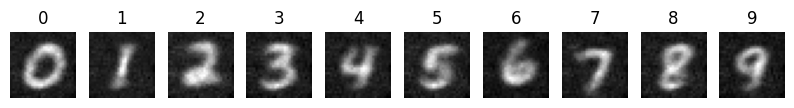

Epoch 0:  53%|█████▎    | 1001/1875 [00:41<00:26, 32.96it/s, Loss: 0.1438346952199936] 

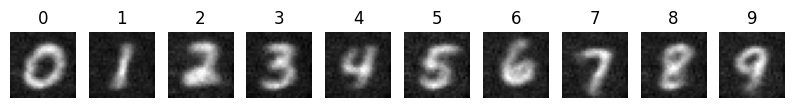

Epoch 0:  80%|████████  | 1501/1875 [01:01<00:13, 27.88it/s, Loss: 0.14956079423427582]

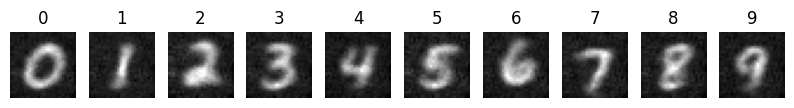

Epoch 0:  98%|█████████▊| 1840/1875 [01:29<00:01, 20.49it/s, Loss: 0.14535585045814514]


KeyboardInterrupt: 

In [197]:
for epoch in range(10):
    with tqdm.tqdm(train_loader) as pbar:
        for x, y in tqdm.tqdm(train_loader):
            model.train()
            x = x.to(device)
            y = y.to(device)
            
            t = torch.randint(0, total_steps, (x.shape[0],), device=device, dtype=torch.float32)
            noise = torch.rand_like(x, device=device)
            noisy_x = noiser(x, noise, t, total_steps)
            target_x = noiser(x, noise, t+1, total_steps)
            
            optimizer.zero_grad()
            output = model(noisy_x, y, t / total_steps)
            loss = criterion(output, target_x)
            loss.backward()
            optimizer.step()
            
            pbar.update()
            pbar.set_postfix_str(f"Loss: {loss.item()}", refresh=True if pbar.n % 50 == 0 else False)
            pbar.set_description(f"Epoch {epoch}")
            
            with torch.no_grad():
                if pbar.n % 500 == 1:
                    # Generate random images
                    model.eval()
                    y = torch.arange(10, device=device)
                    for i in range(total_steps):
                        t = torch.tensor(10 * [i], device=device, dtype=torch.float32) / total_steps
                        noise = torch.rand((10, 1, 28, 28), device=device)
                        noise = model(noise, y, t)

                    y = y.flatten().long().tolist()

                    plt.figure(figsize=(10, 1))
                    for i in range(10):
                        plt.subplot(1, 10, i + 1)
                        plt.imshow(noise[i].detach().cpu().permute(1, 2, 0), cmap='gray')
                        plt.axis('off')
                        plt.title(y[i])
                    plt.show()


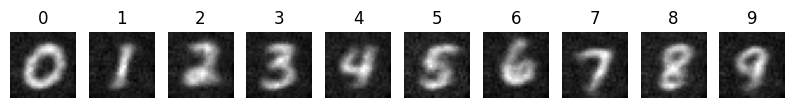

In [194]:
with torch.no_grad():
    # Generate random images
    model.eval()
    y = torch.arange(10, device=device)
    for i in range(total_steps):
        t = torch.tensor(10 * [i], device=device, dtype=torch.float32) / total_steps
        noise = torch.rand((10, 1, 28, 28), device=device)
        noise = model(noise, y, t)

    y = y.flatten().long().tolist()

    plt.figure(figsize=(10, 1))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(noise[i].detach().cpu().permute(1, 2, 0), cmap="gray")
        plt.axis("off")
        plt.title(y[i])
    plt.show()


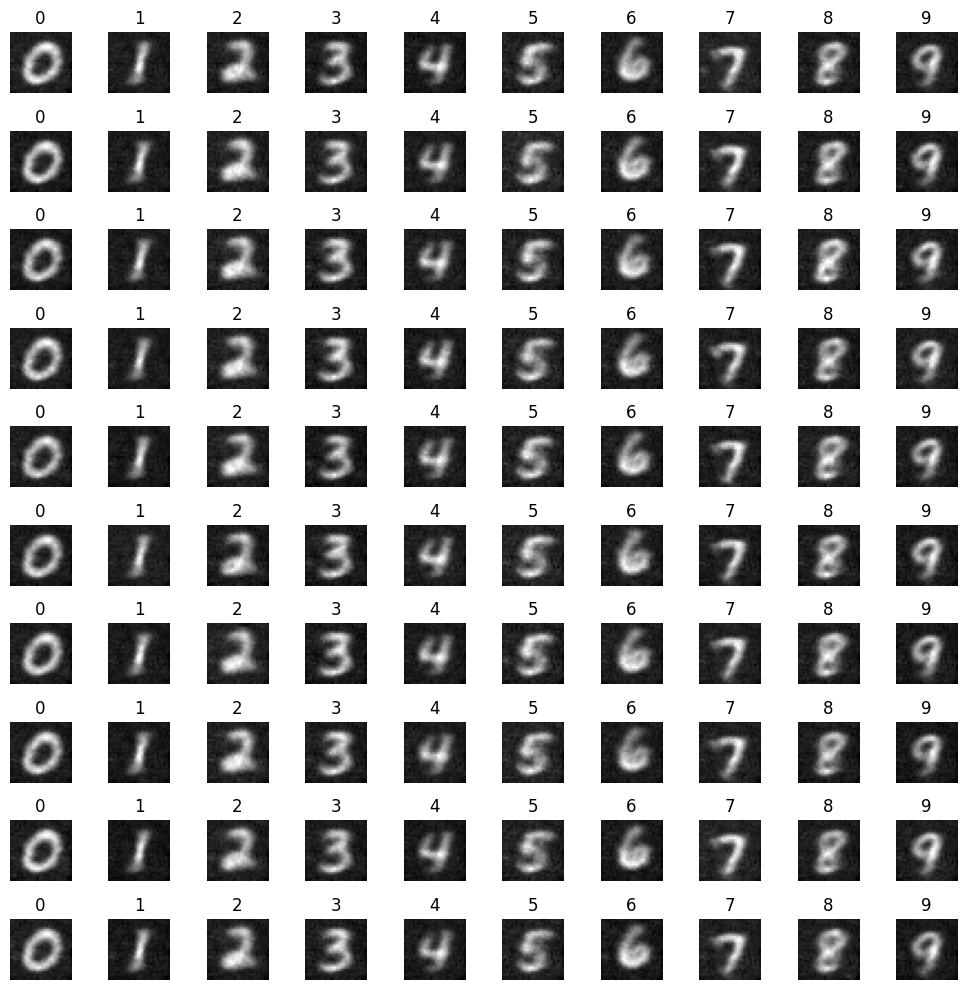

In [195]:
with torch.no_grad():
    # Generate a grid of random images
    model.eval()
    y = torch.arange(10, device=device).repeat(10)

    for i in range(total_steps):
        t = torch.tensor([100 * [i / total_steps]], device=device, dtype=torch.float32)
        noise = torch.rand((100, 1, 28, 28), device=device)

        noise = model(noise, y, t)
        
    y = y.flatten().long().tolist()
    plt.figure(figsize=(10, 10))
    for i in range(100):
        plt.subplot(10, 10, i + 1)
        plt.imshow(noise[i].detach().cpu().permute(1, 2, 0), cmap='gray')
        plt.axis('off')
        plt.title(y[i])
        
    plt.tight_layout()
    plt.show()


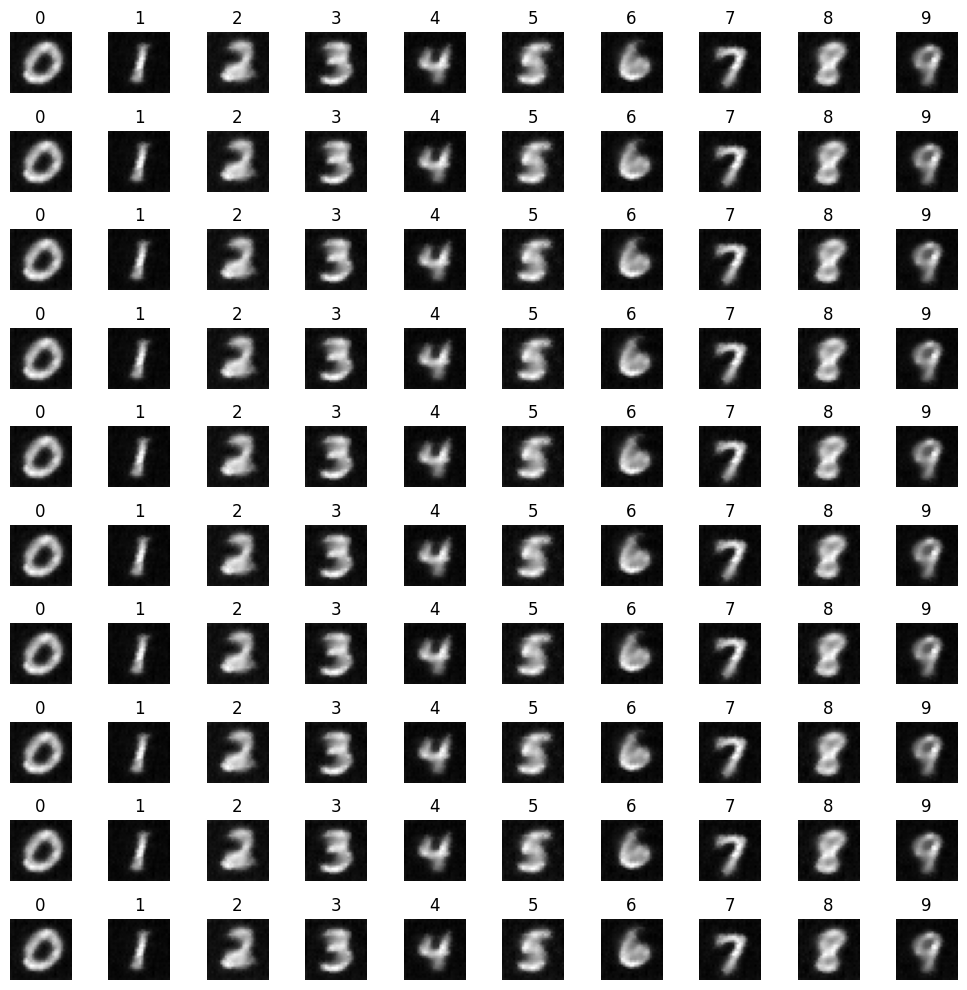

In [160]:
with torch.no_grad():
    # Generate a grid of random images
    model.eval()
    noise = torch.rand((100, 1, 28, 28), device=device)
    y = torch.arange(10, device=device).repeat(10)

    for i in range(total_steps):
        t = torch.tensor([100 * [i / total_steps]], device=device, dtype=torch.float32)
        noise = model(noise, y, t)
        
    y = y.flatten().long().tolist()
    plt.figure(figsize=(10, 10))
    for i in range(100):
        plt.subplot(10, 10, i + 1)
        plt.imshow(noise[i].detach().cpu().permute(1, 2, 0), cmap='gray')
        plt.axis('off')
        plt.title(y[i])
        
    plt.tight_layout()
    plt.show()
